In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from math import sqrt
from matplotlib import pyplot
import numpy


/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [10]:
series = read_csv('../data/new_single_cluster_0.csv', usecols=[1], engine='python')
series00 = read_csv('../data/new_single_cluster_00.csv', usecols=[1], engine='python')
series000 = read_csv('../data/new_single_cluster_000.csv', usecols=[1], engine='python')
series0000 = read_csv('../data/new_single_cluster_0000.csv', usecols=[1], engine='python')
series00000 = read_csv('../data/new_single_cluster_00000.csv', usecols=[1], engine='python')

# transform data to be stationary
raw_values = series.values
raw_values00 = series00.values
raw_values000 = series000.values
raw_values0000 = series0000.values
raw_values00000 = series00000.values

In [22]:
series2 = read_csv('../data/new_single_cluster_1.csv', usecols=[1], engine='python')
series22 = read_csv('../data/new_single_cluster_11.csv', usecols=[1], engine='python')
series222 = read_csv('../data/new_single_cluster_111.csv', usecols=[1], engine='python')
series2222 = read_csv('../data/new_single_cluster_1111.csv', usecols=[1], engine='python')
series22222 = read_csv('../data/new_single_cluster_1111.csv', usecols=[1], engine='python')


# transform data to be stationary
raw_values2 = series2.values
raw_values22 = series22.values
raw_values222 = series222.values
raw_values2222 = series2222.values
raw_values22222 = series22222.values


In [23]:
series3 = read_csv('../data/new_single_cluster_2.csv', usecols=[1], engine='python')
series33 = read_csv('../data/new_single_cluster_22.csv', usecols=[1], engine='python')
series333 = read_csv('../data/new_single_cluster_222.csv', usecols=[1], engine='python')
series3333 = read_csv('../data/new_single_cluster_2222.csv', usecols=[1], engine='python')
series33333 = read_csv('../data/new_single_cluster_22222.csv', usecols=[1], engine='python')


# transform data to be stationary
raw_values3 = series3.values
raw_values33 = series33.values
raw_values333 = series333.values
raw_values3333 = series3333.values
raw_values33333 = series33333.values

In [24]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [25]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [26]:


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons, patience=3):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')

	early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)

	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, callbacks=[early_stopping])
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [41]:
### Global Variables
NB_EPOCH = 10
NEURONS = 32
BATCH_SIZE = 1
TEST_SIZE = -3

In [42]:
def train(value):
	diff_values = difference(value, 1)

	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values

	# split data into train and test-sets
	train, test = supervised_values[0:TEST_SIZE], supervised_values[TEST_SIZE:]

	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)

	# fit the model
	lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)

	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(value, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
		expected = value[len(train) + i + 1]
		print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


	# report performance
	rmse = sqrt(mean_squared_error(value[TEST_SIZE:], predictions))
	print('Test RMSE: %.3f' % rmse)

	mae = mean_absolute_error(value[TEST_SIZE:], predictions)
	print('Test MAE: %.3f' % mae)
	# line plot of observed vs predicted
	pyplot.plot(raw_values[TEST_SIZE:])
	pyplot.plot(predictions)
	pyplot.show()

### For Cluster 0

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=1918.447978, Expected=2100.000000
1/1 [==============================] - 0s 11ms/step
Month=2, Predicted=2202.168701, Expected=2350.000000
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=2440.785254, Expected=2250.000000
Test RMSE: 174.370
Test MAE: 173.390


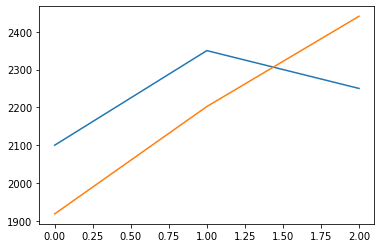

In [43]:
train(raw_values)

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=1783.986173, Expected=2133.000000
1/1 [==============================] - 0s 11ms/step
Month=2, Predicted=2086.466727, Expected=2328.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=2258.457256, Expected=2431.000000
Test RMSE: 264.525
Test MAE: 254.363


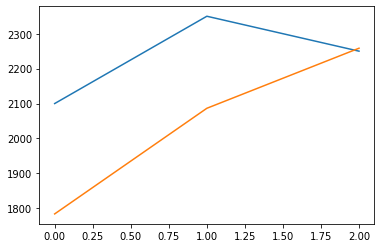

In [44]:
train(raw_values00)

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=1783.546104, Expected=2126.000000
1/1 [==============================] - 0s 11ms/step
Month=2, Predicted=2053.406583, Expected=2305.000000
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=2193.019946, Expected=2489.000000
Test RMSE: 298.986
Test MAE: 296.676


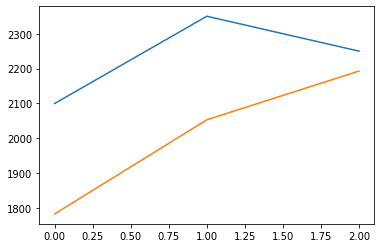

In [45]:
train(raw_values000)

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=1713.437657, Expected=2188.000000
1/1 [==============================] - 0s 11ms/step
Month=2, Predicted=2143.904781, Expected=2375.000000
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=2303.460084, Expected=2429.000000
Test RMSE: 313.249
Test MAE: 277.066


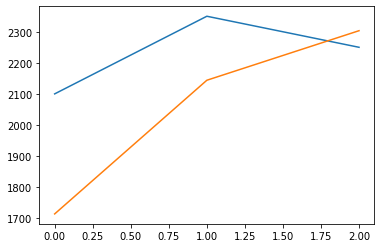

In [46]:
train(raw_values0000)

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=1793.545107, Expected=2146.000000
1/1 [==============================] - 0s 11ms/step
Month=2, Predicted=2061.342873, Expected=2347.000000
1/1 [==============================] - 0s 14ms/step
Month=3, Predicted=2214.974947, Expected=2456.000000
Test RMSE: 296.602
Test MAE: 293.046


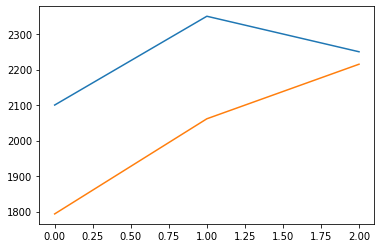

In [47]:
train(raw_values00000)

### For Cluster 1

1/1 [==============================] - 0s 14ms/step
Month=1, Predicted=1448.991105, Expected=1933.000000
1/1 [==============================] - 0s 13ms/step
Month=2, Predicted=1803.550001, Expected=2028.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=1860.503334, Expected=2111.000000
Test RMSE: 340.290
Test MAE: 319.652


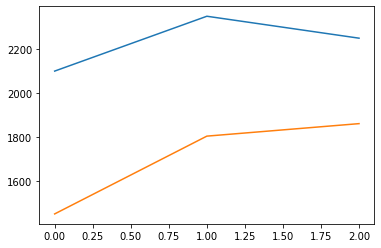

In [48]:
train(raw_values2)

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=1644.872891, Expected=1926.000000
1/1 [==============================] - 0s 11ms/step
Month=2, Predicted=1873.638379, Expected=2105.000000
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=1971.009073, Expected=2089.000000
Test RMSE: 220.969
Test MAE: 210.160


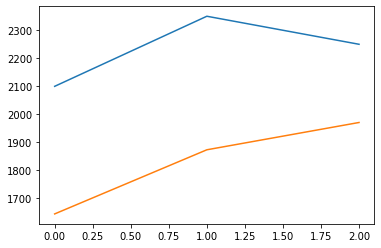

In [49]:
train(raw_values22)

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=1577.908617, Expected=1988.000000
1/1 [==============================] - 0s 16ms/step
Month=2, Predicted=1850.691263, Expected=2075.000000
1/1 [==============================] - 0s 16ms/step
Month=3, Predicted=1921.530778, Expected=2109.000000
Test RMSE: 290.766
Test MAE: 273.956


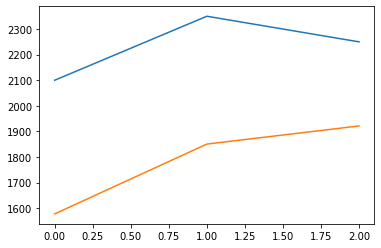

In [50]:
train(raw_values222)

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=783.928913, Expected=2146.000000
1/1 [==============================] - 0s 11ms/step
Month=2, Predicted=1119.996386, Expected=2077.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=1060.127838, Expected=2056.000000
Test RMSE: 1119.949
Test MAE: 1104.982


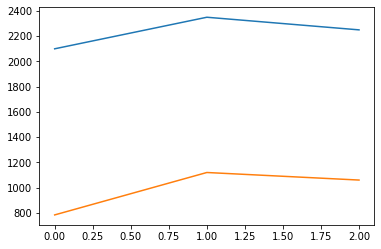

In [51]:
train(raw_values2222)

1/1 [==============================] - 0s 14ms/step
Month=1, Predicted=1654.714319, Expected=2146.000000
1/1 [==============================] - 0s 14ms/step
Month=2, Predicted=2019.462790, Expected=2077.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=1984.283301, Expected=2056.000000
Test RMSE: 288.569
Test MAE: 206.847


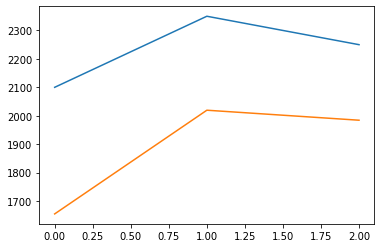

In [52]:
train(raw_values22222)

### For Cluster 2

1/1 [==============================] - 0s 15ms/step
Month=1, Predicted=2099.398432, Expected=2633.000000
1/1 [==============================] - 0s 14ms/step
Month=2, Predicted=2647.238581, Expected=2798.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=2729.942524, Expected=2711.000000
Test RMSE: 320.322
Test MAE: 234.435


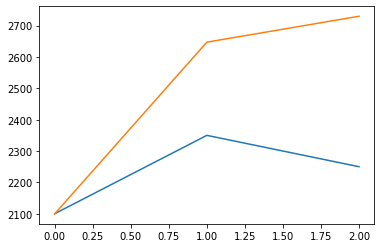

In [53]:
train(raw_values3)

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=2195.461787, Expected=2646.000000
1/1 [==============================] - 0s 10ms/step
Month=2, Predicted=2663.007754, Expected=2785.000000
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=2704.430421, Expected=2889.000000
Test RMSE: 289.789
Test MAE: 252.367


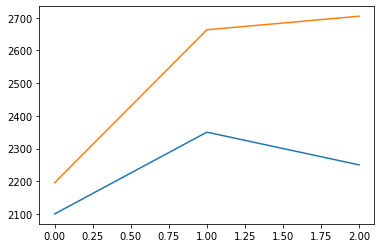

In [54]:
train(raw_values33)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=2158.615354, Expected=2775.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=2718.389075, Expected=2784.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=2665.980975, Expected=2856.000000
Test RMSE: 374.318
Test MAE: 290.672


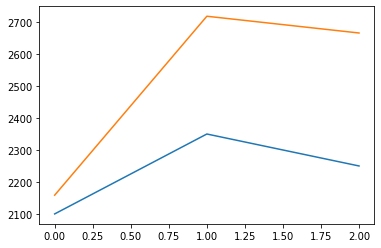

In [55]:
train(raw_values333)

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=2172.295352, Expected=2761.000000
1/1 [==============================] - 0s 13ms/step
Month=2, Predicted=2673.374015, Expected=2752.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=2596.859146, Expected=2881.000000
Test RMSE: 380.128
Test MAE: 317.157


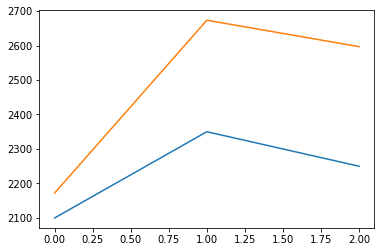

In [56]:
train(raw_values3333)

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=2124.797496, Expected=2785.000000
1/1 [==============================] - 0s 18ms/step
Month=2, Predicted=2696.429783, Expected=2794.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=2618.387737, Expected=2872.000000
Test RMSE: 412.192
Test MAE: 337.128


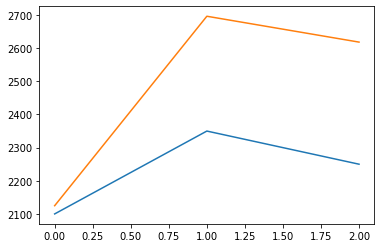

In [57]:
train(raw_values33333)